<a href="https://colab.research.google.com/github/Medouchene/Deep-Learning/blob/main/mlp_pytorch_softmax_crossentr_ouchene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [14]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

ModuleNotFoundError: No module named 'watermark'

# MLP With Different Loss Functions

## Imports

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline

In [16]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

## Settings and Dataset

In [17]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


## Model

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time

##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)


# Define two MLP classes: one with ReLU, one with Sigmoid
class MLPReLU(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()

        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()

        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        self.linear_out.weight.data.normal_(0.0, 0.1)
        self.linear_out.bias.data.zero_()

    def forward(self, x):
        out = F.relu(self.linear_1(x))
        logits = self.linear_out(out)
        return logits


class MLPSigmoid(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()

        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()

        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        self.linear_out.weight.data.normal_(0.0, 0.1)
        self.linear_out.bias.data.zero_()

    def forward(self, x):
        out = torch.sigmoid(self.linear_1(x))
        logits = self.linear_out(out)
        return logits


#################################
### Training Function
#################################

def train_model(model, optimizer, activation_type="ReLU"):
    minibatch_cost = []
    epoch_cost = []
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()
            cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            minibatch_cost.append(cost.item())
            if not batch_idx % 50:
                print(f'{activation_type} - Epoch: {epoch+1:03d}/{NUM_EPOCHS} | Batch {batch_idx:03d}/{len(train_loader)} | Cost: {cost.item():.4f}')

        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print(f'{activation_type} - Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train Cost: {cost:.4f}')
        print(f'Time elapsed: {(time.time() - start_time) / 60:.2f} min')

    print(f'{activation_type} - Total Training Time: {(time.time() - start_time) / 60:.2f} min')
    return minibatch_cost, epoch_cost


def compute_loss(net, data_loader):
    net.eval()
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, targets)
            curr_loss += loss.item()
    return curr_loss / (cnt + 1)


#################################
### Model Initialization
#################################

torch.manual_seed(RANDOM_SEED)
model_relu = MLPReLU(num_features=28*28, num_hidden=100, num_classes=10).to(DEVICE)
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=0.1)

model_sigmoid = MLPSigmoid(num_features=28*28, num_hidden=100, num_classes=10).to(DEVICE)
optimizer_sigmoid = torch.optim.SGD(model_sigmoid.parameters(), lr=0.1)

#################################
### Training ReLU Model
#################################
print("\nTraining model with ReLU activation:")
minibatch_cost_relu, epoch_cost_relu = train_model(model_relu, optimizer_relu, activation_type="ReLU")

#################################
### Training Sigmoid Model
#################################
print("\nTraining model with Sigmoid activation:")
minibatch_cost_sigmoid, epoch_cost_sigmoid = train_model(model_sigmoid, optimizer_sigmoid, activation_type="Sigmoid")



Training model with ReLU activation:
ReLU - Epoch: 001/20 | Batch 000/600 | Cost: 2.4437
ReLU - Epoch: 001/20 | Batch 050/600 | Cost: 0.7404
ReLU - Epoch: 001/20 | Batch 100/600 | Cost: 0.4807
ReLU - Epoch: 001/20 | Batch 150/600 | Cost: 0.5858
ReLU - Epoch: 001/20 | Batch 200/600 | Cost: 0.5390
ReLU - Epoch: 001/20 | Batch 250/600 | Cost: 0.2883
ReLU - Epoch: 001/20 | Batch 300/600 | Cost: 0.3610
ReLU - Epoch: 001/20 | Batch 350/600 | Cost: 0.2462
ReLU - Epoch: 001/20 | Batch 400/600 | Cost: 0.3928
ReLU - Epoch: 001/20 | Batch 450/600 | Cost: 0.3495
ReLU - Epoch: 001/20 | Batch 500/600 | Cost: 0.3377
ReLU - Epoch: 001/20 | Batch 550/600 | Cost: 0.2411
ReLU - Epoch: 001/20 Train Cost: 0.2833
Time elapsed: 0.30 min
ReLU - Epoch: 002/20 | Batch 000/600 | Cost: 0.2504
ReLU - Epoch: 002/20 | Batch 050/600 | Cost: 0.1433
ReLU - Epoch: 002/20 | Batch 100/600 | Cost: 0.2248
ReLU - Epoch: 002/20 | Batch 150/600 | Cost: 0.3100
ReLU - Epoch: 002/20 | Batch 200/600 | Cost: 0.2162
ReLU - Epoch: 0

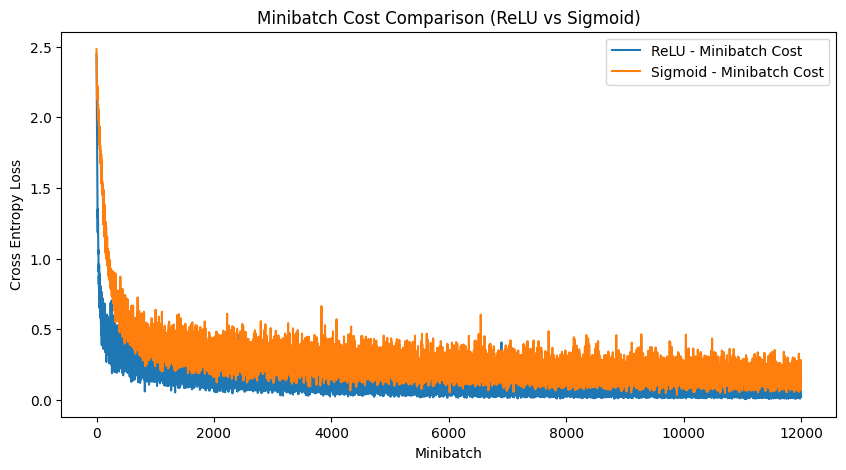

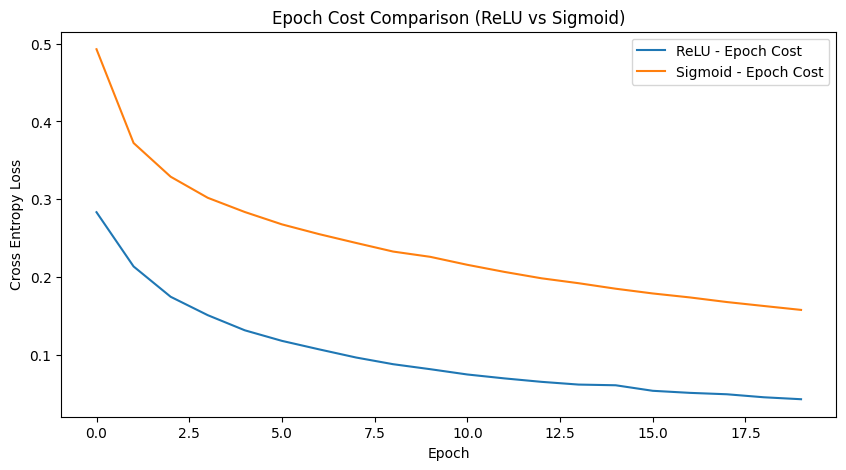

In [18]:

# Plot minibatch costs for ReLU and Sigmoid
plt.figure(figsize=(10, 5))
plt.plot(range(len(minibatch_cost_relu)), minibatch_cost_relu, label='ReLU - Minibatch Cost')
plt.plot(range(len(minibatch_cost_sigmoid)), minibatch_cost_sigmoid, label='Sigmoid - Minibatch Cost')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Minibatch')
plt.legend()
plt.title('Minibatch Cost Comparison (ReLU vs Sigmoid)')
plt.show()

# Plot epoch costs for ReLU and Sigmoid
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_cost_relu)), epoch_cost_relu, label='ReLU - Epoch Cost')
plt.plot(range(len(epoch_cost_sigmoid)), epoch_cost_sigmoid, label='Sigmoid - Epoch Cost')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Epoch Cost Comparison (ReLU vs Sigmoid)')
plt.show()



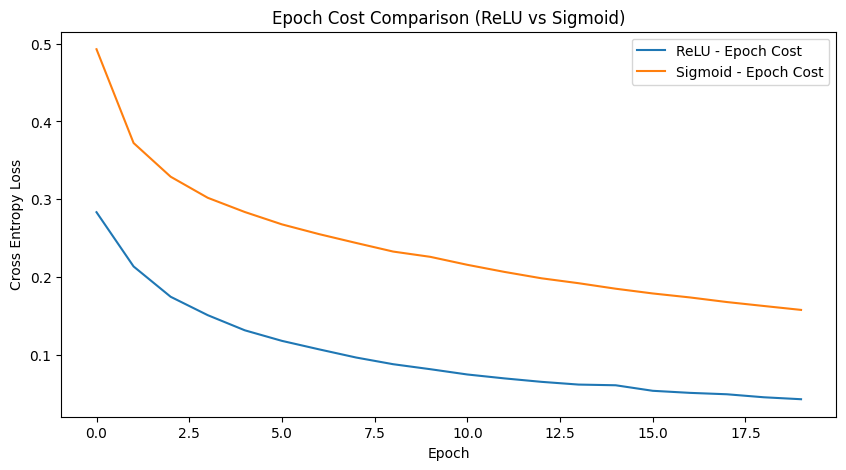

In [19]:

# Plot epoch costs for ReLU and Sigmoid
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_cost_relu)), epoch_cost_relu, label='ReLU - Epoch Cost')
plt.plot(range(len(epoch_cost_sigmoid)), epoch_cost_sigmoid, label='Sigmoid - Epoch Cost')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Epoch Cost Comparison (ReLU vs Sigmoid)')
plt.show()


In [20]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


# Calcul de la précision pour le modèle utilisant ReLU
print('Training Accuracy (ReLU): %.2f' % compute_accuracy(model_relu, train_loader))
print('Test Accuracy (ReLU): %.2f' % compute_accuracy(model_relu, test_loader))

# Calcul de la précision pour le modèle utilisant Sigmoid
print('Training Accuracy (Sigmoid): %.2f' % compute_accuracy(model_sigmoid, train_loader))
print('Test Accuracy (Sigmoid): %.2f' % compute_accuracy(model_sigmoid, test_loader))

Training Accuracy (ReLU): 98.92
Test Accuracy (ReLU): 97.57
Training Accuracy (Sigmoid): 95.52
Test Accuracy (Sigmoid): 95.28
